<a href="https://colab.research.google.com/github/Briankim254/Malaria-Detection-with-TensorFlow/blob/main/Malaria_Detection_with_TensorFlow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install tensorflow-datasets

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import gc

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.15.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [ ]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteQB5J6Z/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print("Number of classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Number of classes: 2
Class names: ['parasitized', 'uninfected']


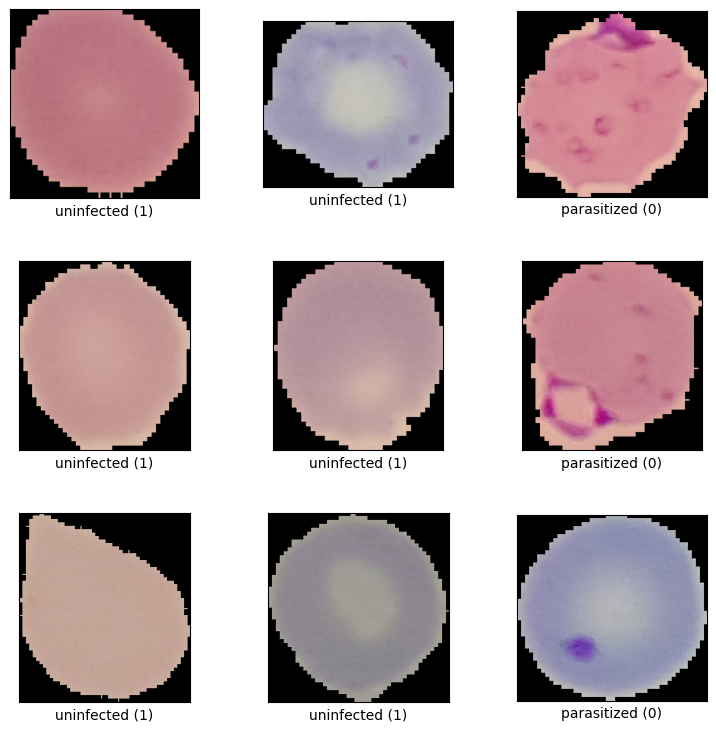

In [ ]:
vis = tfds.visualization.show_examples(ds, info)

                                               image  label
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0
[0 1]


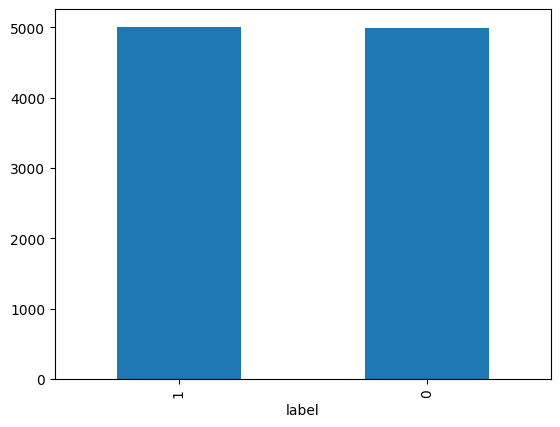

In [ ]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

df = tfds.as_dataframe(ds.take(10000))

print(df.head())

print(df['label'].unique())

df['label'].value_counts().plot(kind='bar')
plt.show()



# Data Augmentation and Processing

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

In [ ]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (103, 103, 3)
Label:  1


In [ ]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

In [ ]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

In [ ]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

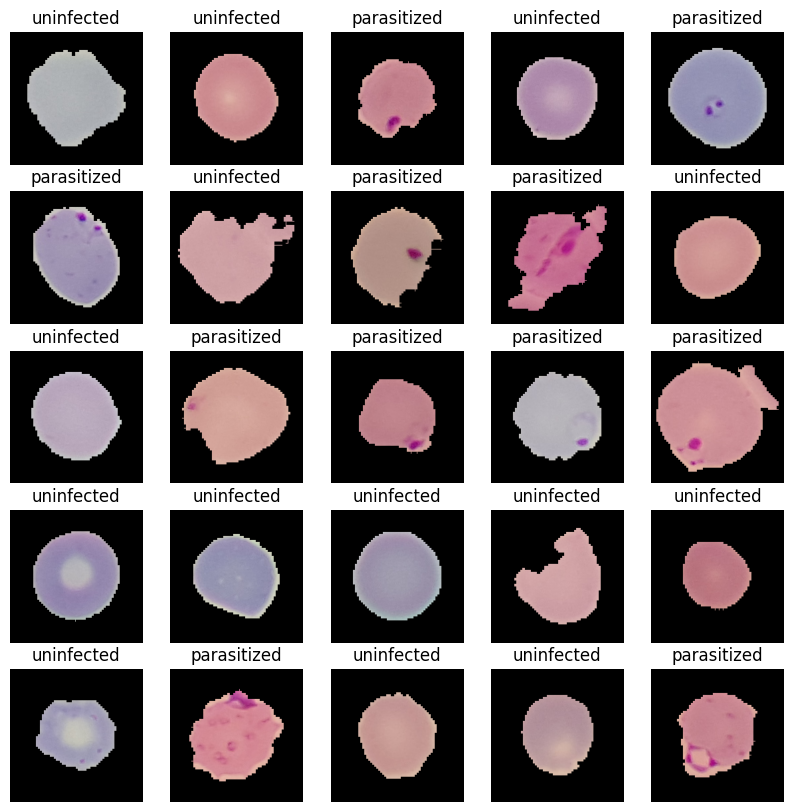

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
model = build_model()
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
          ]
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics= metrics
)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.keras",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Training

In [ ]:
history = model.fit(
    padded_train_ds, epochs=20,
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/20
603/603 [==============================] - 58s 96ms/step - loss: 0.2030 - accuracy: 0.9397 - precision: 0.9267 - recall: 0.9549 - val_loss: 0.3911 - val_accuracy: 0.9422 - val_precision: 0.9591 - val_recall: 0.9246 - lr: 0.0100
Epoch 2/20
603/603 [==============================] - 53s 87ms/step - loss: 0.1772 - accuracy: 0.9476 - precision: 0.9379 - recall: 0.9589 - val_loss: 0.1470 - val_accuracy: 0.9511 - val_precision: 0.9372 - val_recall: 0.9678 - lr: 0.0089
Epoch 3/20
603/603 [==============================] - 52s 87ms/step - loss: 0.1694 - accuracy: 0.9519 - precision: 0.9407 - recall: 0.9647 - val_loss: 0.1617 - val_accuracy: 0.9482 - val_precision: 0.9230 - val_recall: 0.9789 - lr: 0.0079
Epoch 4/20
603/603 [==============================] - 51s 85ms/step - loss: 0.1654 - accuracy: 0.9498 - precision: 0.9408 - recall: 0.9601 - val_loss: 0.1425 - val_accuracy: 0.9494 - val_precision: 0.9301 - val_recall: 0.9726 - lr: 0.0071
Epoch 5/20
603/603 [========================

# Evaluation

In [ ]:
padded_test_ds = (
     test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

In [ ]:
model.evaluate(padded_test_ds)

130/130 [==============================] - 5s 36ms/step - loss: 0.1349 - accuracy: 0.9606 - precision: 0.9465 - recall: 0.9756


[0.13492250442504883, 0.9605708718299866, 0.9464708566665649, 0.9755859375]

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 16)      0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 50, 50, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 25, 25, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 12, 12, 128)       27072     
                                                      

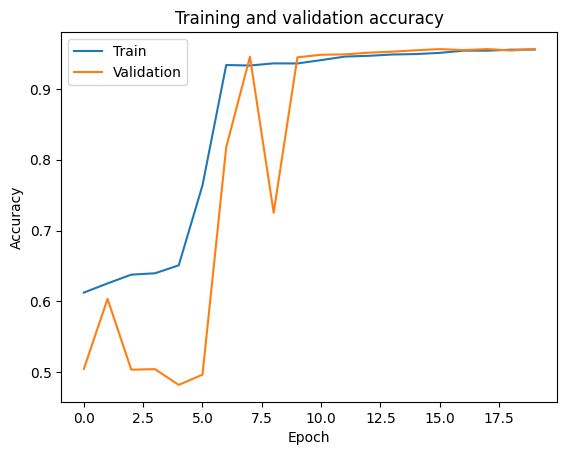

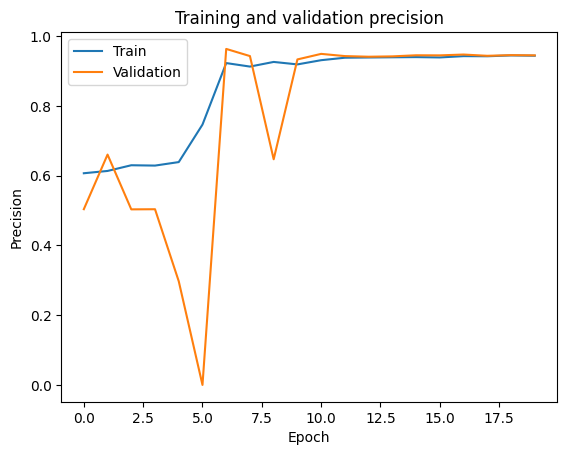

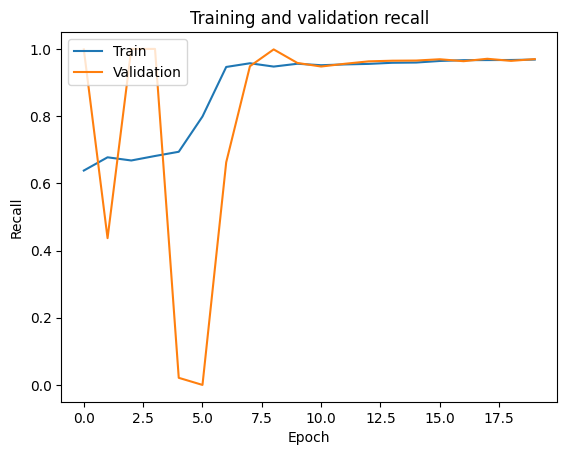

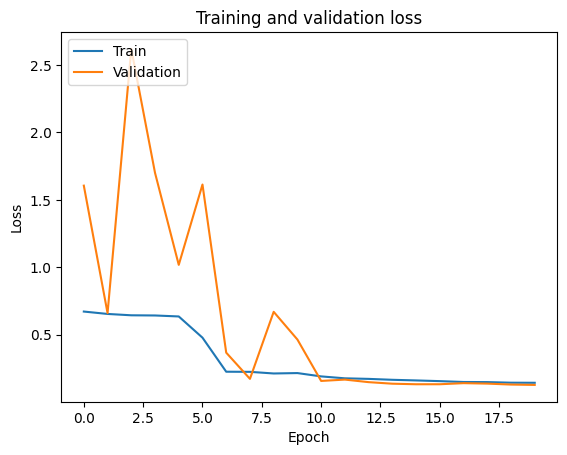

In [ ]:

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Training and validation precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Training and validation recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
